# Robustness

## Summary:

 * All the feature groups in this notebook are from Nominal Categories with more than 200 languages -- there are 68 in all, each comprising 3 to 6 features.

 * It seems that the good groups we found in Nominal Categories are all groups with low coverage -- it could be that the good silhouettes were obtained because the number of languages in the most frequent families are small.
     - In [3] 
 
 * Searching for good groups by chunking the top quarantile of gen2 and gen4 to four and testing all 16 combinations, yields the same loadings.
     - In [5], In[10] -- In[12]
     - But this is to be expected, since gen2 and gen4 are well correlated (  In [4] ) ! I don't think this test is very informative 
 
 * Searching for good groups by average of 2-cluster silhouettes for frequent families yields the same groups more or less and the same prominent featues.
   - In [13], In [14]
   - again the correlation in In [6] can tell you that. 
 
 * Standard deviations of silhouettes seem to be a little lower in group analysis.
   - the comparison is between the top 21 groups whose average 2-cluster silhouette is above the 0.7 quantile and the top 21 features by average single-feature 2-cluster silhouette score.
   - The graph in In [18] shows the SEs - in parentheses - by pairs of families. 
   - The graph in In [20] shows the values, means and SEs of various silhouette-based scorings

In [1]:
from locator import *
from phonstats import agstats
import pandas as pd
import numpy as np
%matplotlib inline
nomcats = pd.read_pickle('nominalcats-200.pkl')
print("Number of Feature Groups that Cover at least 200 Languages out of Nominal Categories:",len(nomcats))

Number of Feature Groups that Cover at least 200 Languages out of Nominal Categories: 68


In [2]:
#collect relevant data
sils = pd.DataFrame([[
            g.numrows,g.consistent_families[0][1],
            g.consistent_families[1][1],
            g.best_silhouette('genetic',2)[0],
            g.best_silhouette('genetic',4)[0],
            g.pair_sils().mean()
        ] for g in nomcats],
        columns=['total_languages','family1 count','family2 count','gen2','gen4','gen2_average'])
sils.describe()

,total_languages,family1 count,family2 count,gen2,gen4,gen2_average
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,264.514706,28.808824,20.176471,0.374862,0.107384,0.258016
std,86.600557,14.192974,8.802885,0.216148,0.097623,0.131397
min,200.000000,16.000000,12.000000,0.040639,-0.046319,0.040626
25%,206.500000,18.000000,15.000000,0.176891,0.050163,0.167897
50%,220.000000,24.000000,16.000000,0.384162,0.083329,0.208945
75%,287.000000,28.250000,20.250000,0.551073,0.144198,0.307697
max,630.000000,72.000000,46.000000,0.802500,0.413577,0.557833


## Good Groups Have Small Coverage
First, we have to make sure that the good groups are not just the ones whoes family1 and famil2 counts are small -- and the good separation is just a side effect of there being less languages to separate

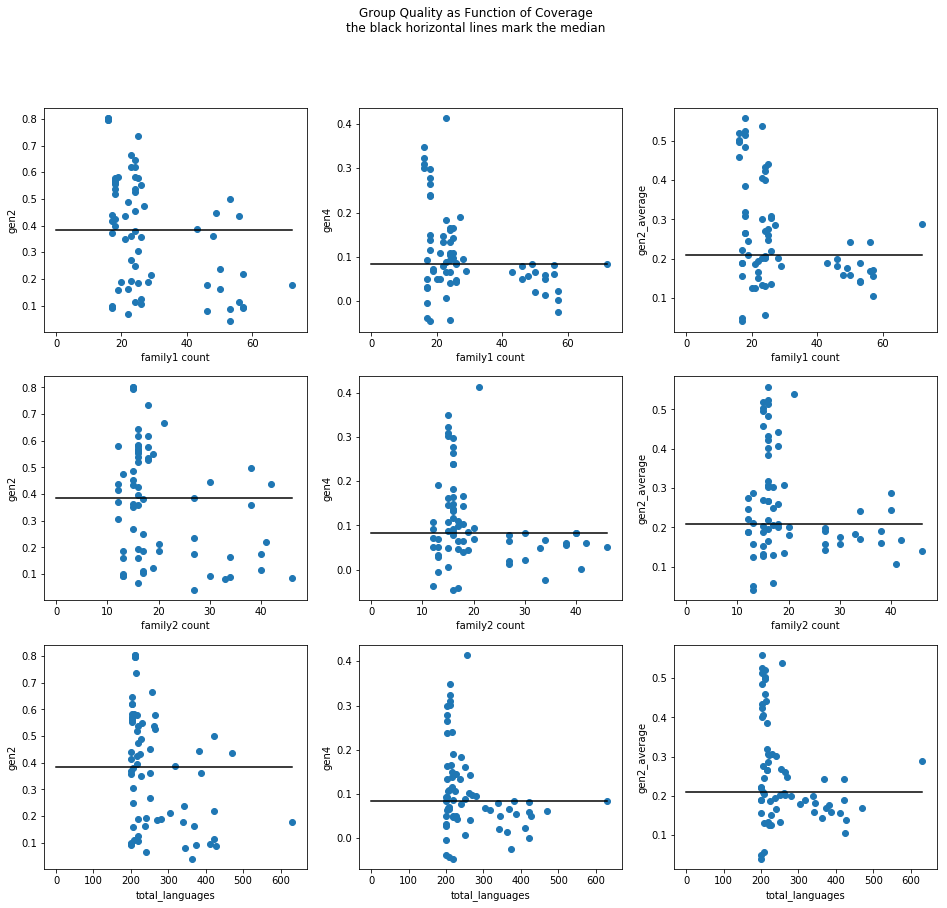

In [3]:
fig,axes =  plt.subplots(nrows=3,ncols=3,figsize=(16,14))
for ax,(x,y) in zip(axes.flatten(),[
        ('family1 count','gen2'),
        ('family1 count','gen4'),
        ('family1 count','gen2_average'),
        ('family2 count','gen2'),
        ('family2 count','gen4'),
        ('family2 count','gen2_average'),
        ('total_languages','gen2'),
        ('total_languages','gen4'),
        ('total_languages','gen2_average')
    ]):
    ax.plot((0,sils[x].max()),(sils[y].median(),sils[y].median()), 'k-')
    ax.set_ylabel(y)
    ax.set_xlabel(x)
    ax.scatter(sils[x],sils[y])
plt.suptitle("Group Quality as Function of Coverage\nthe black horizontal lines mark the median")
plt.show()

And indeed almost all of the good groups are those that have little languages. The correlation between total number of languages and the three quality indices are all negative though not very high:

In [4]:
sils.corr()

,total_languages,family1 count,family2 count,gen2,gen4,gen2_average
total_languages,1.000000,0.948983,0.924082,-0.375722,-0.296414,-0.304909
family1 count,0.948983,1.000000,0.934460,-0.433924,-0.380106,-0.342836
family2 count,0.924082,0.934460,1.000000,-0.327194,-0.269844,-0.250957
gen2,-0.375722,-0.433924,-0.327194,1.000000,0.666897,0.756437
gen4,-0.296414,-0.380106,-0.269844,0.666897,1.000000,0.830645
gen2_average,-0.304909,-0.342836,-0.250957,0.756437,0.830645,1.000000


## Grid Search of Good Group-Collections and Corresponding Loadings
Assuming Point 1 is not a prolem, check that cropping the best groups by different criteria yields the same prominent features

### using combination of cutoffs for gen2 and gen4

In [5]:
# make a 4x4 grid by dividing the range between max and median for both silhouette kinds by 4
grid = pd.DataFrame((sils.quantile(0.5) + i * (sils.max() - sils.quantile(0.5))/4 for i in range(4)))[['gen2','gen4']]
grid

,gen2,gen4
0,0.384162,0.083329
1,0.488746,0.165891
2,0.593331,0.248453
3,0.697915,0.331015


In [6]:
# scan through all pairs each yielding a good set
dat = dict()
total_groups = 0
for g2 in grid['gen2']:
    for g4 in grid['gen4']:
        good = [g for g in nomcats if g.best_silhouette('genetic',2)[0] >= g2 and g.best_silhouette('genetic',4)[0] >= g4 ]
        total_groups += len(good)
        #for each good set, compute the mean loadings
        loadings  = agstats(good)
        pc1 = loadings.loc['component 1']
        pc1 = pc1[pc1.mean_loading.notnull()].sort_values(by='mean_loading')
        pc2 = loadings.loc['component 2']
        pc2 = pc2[pc2.mean_loading.notnull()].sort_values(by='mean_loading')
        # for each feature, register its place and contribution to pc1 and pc2
        for c in pc1.index:
            if c not in dat:
                dat[c] = {
                    'comp1' : {
                        'place' : list(),
                        'contrib' : list()
                    },
                    'comp2':{
                        'place': list(),
                        'contrib' : list()
                    },
                    'participation' : list()
                }

            dat[c]['comp1']['place'].append(pc1.index.get_loc(c))
            dat[c]['comp1']['contrib'].append(pc1.loc[c]['mean_loading'])
            dat[c]['comp2']['contrib'].append(pc2.loc[c]['mean_loading'])
            dat[c]['comp2']['place'].append(pc2.index.get_loc(c))
            dat[c]['participation'].append(len([g for g in good if c in g.cols]))

In [7]:
total_groups

116

In [8]:
strengths = pd.DataFrame([
        {
            'pc1': np.mean(d['comp1']['contrib']),
            'pc1std' : np.std(d['comp1']['contrib']),
            'pc1ranks' : np.mean(d['comp1']['place']),
            'pc1rankstd' : np.std(d['comp1']['place']),
            'pc2': np.mean(d['comp2']['contrib']),
            'pc2std' : np.std(d['comp2']['contrib']),
            'pc2ranks' : np.mean(d['comp2']['place']),
            'pc2rankstd' : np.std(d['comp2']['place']),
            'participation' : sum(d['participation'])
        }
     for f,d in dat.items()], index=dat.keys())

In [9]:
strengths = strengths[strengths.participation > 2]

In [10]:
strengths.sort_values(by='pc1',ascending=False)

,participation,pc1,pc1ranks,pc1rankstd,pc1std,pc2,pc2ranks,pc2rankstd,pc2std
31A,68,0.473504,4.687500,2.364285,0.024250,0.058884,0.8125,0.881671,0.019886
50A,17,0.430603,5.666667,1.699673,0.074039,0.267429,3.5000,1.892969,0.163168
32A,64,0.403932,3.466667,2.276449,0.036668,0.224277,2.0000,1.211060,0.235282
49A,16,0.386049,4.000000,1.527525,0.056436,0.051284,1.0000,1.414214,0.029732
30A,70,0.378361,2.625000,1.832860,0.015697,0.062430,1.3125,0.768013,0.024553
48A,7,0.203373,4.000000,3.000000,0.157502,0.569796,7.5000,0.500000,0.162455
33A,42,0.093988,1.375000,1.218349,0.067900,0.648775,4.8750,1.536026,0.189703
57A,3,0.090143,3.000000,0.000000,0.000000,0.684473,10.0000,0.000000,0.000000
51A,70,0.075962,1.125000,2.496873,0.122043,0.852164,4.1250,1.452369,0.177347
44A,16,0.027649,0.750000,0.829156,0.020591,0.694063,6.2500,1.479020,0.246030


In [11]:
strengths.sort_values(by='pc1ranks',ascending=False)

,participation,pc1,pc1ranks,pc1rankstd,pc1std,pc2,pc2ranks,pc2rankstd,pc2std
50A,17,0.430603,5.666667,1.699673,0.074039,0.267429,3.5000,1.892969,0.163168
31A,68,0.473504,4.687500,2.364285,0.024250,0.058884,0.8125,0.881671,0.019886
49A,16,0.386049,4.000000,1.527525,0.056436,0.051284,1.0000,1.414214,0.029732
48A,7,0.203373,4.000000,3.000000,0.157502,0.569796,7.5000,0.500000,0.162455
32A,64,0.403932,3.466667,2.276449,0.036668,0.224277,2.0000,1.211060,0.235282
57A,3,0.090143,3.000000,0.000000,0.000000,0.684473,10.0000,0.000000,0.000000
30A,70,0.378361,2.625000,1.832860,0.015697,0.062430,1.3125,0.768013,0.024553
33A,42,0.093988,1.375000,1.218349,0.067900,0.648775,4.8750,1.536026,0.189703
51A,70,0.075962,1.125000,2.496873,0.122043,0.852164,4.1250,1.452369,0.177347
44A,16,0.027649,0.750000,0.829156,0.020591,0.694063,6.2500,1.479020,0.246030


In [12]:
strengths.sort_values(by='pc2',ascending=False)

,participation,pc1,pc1ranks,pc1rankstd,pc1std,pc2,pc2ranks,pc2rankstd,pc2std
51A,70,0.075962,1.125000,2.496873,0.122043,0.852164,4.1250,1.452369,0.177347
44A,16,0.027649,0.750000,0.829156,0.020591,0.694063,6.2500,1.479020,0.246030
57A,3,0.090143,3.000000,0.000000,0.000000,0.684473,10.0000,0.000000,0.000000
33A,42,0.093988,1.375000,1.218349,0.067900,0.648775,4.8750,1.536026,0.189703
48A,7,0.203373,4.000000,3.000000,0.157502,0.569796,7.5000,0.500000,0.162455
50A,17,0.430603,5.666667,1.699673,0.074039,0.267429,3.5000,1.892969,0.163168
32A,64,0.403932,3.466667,2.276449,0.036668,0.224277,2.0000,1.211060,0.235282
30A,70,0.378361,2.625000,1.832860,0.015697,0.062430,1.3125,0.768013,0.024553
31A,68,0.473504,4.687500,2.364285,0.024250,0.058884,0.8125,0.881671,0.019886
49A,16,0.386049,4.000000,1.527525,0.056436,0.051284,1.0000,1.414214,0.029732


This is in line with what we got here:
 https://github.com/ilay32/wals-project/blob/master/single-feature.ipynb In [46] , In[47]
 
 
 ### By Average of 2-cluster Silhouettes
 Tested family pairs are all pairs among families whose counts are in the top 4 (there can be more than 4 families since there are ties). The good collection is the 0.7 quantile.

In [13]:
good_by_average = [g for g in nomcats if g.pair_sils().mean() > sils['gen2_average'].quantile(0.7)]
loadings = agstats(good_by_average)
pc1 = loadings.loc['component 1']
pc1 = pc1[pc1.mean_loading.notnull() & (pc1.participation > 2)].sort_values(by='mean_loading',ascending=False)
pc1

,mean_loading,std,participation,subarea
features,,,,
31A,0.466678,0.0839198,7,None
32A,0.422809,0.082761,7,None
50A,0.413542,0.104499,7,None
30A,0.380163,0.0767466,7,None
49A,0.374743,0.0780295,7,None
51A,0.324885,0.248932,11,None
33A,0.128709,0.115259,12,None
44A,0.0504757,0.0458076,3,None


In [14]:
pc2 = loadings.loc['component 2']
pc2 = pc2[pc2.mean_loading.notnull() & (pc2.participation > 2)].sort_values(by='mean_loading',ascending=False)
pc2

,mean_loading,std,participation,subarea
features,,,,
33A,0.536204,0.303062,12,None
44A,0.500239,0.303026,3,None
51A,0.451315,0.381498,11,None
50A,0.292385,0.238937,7,None
32A,0.111772,0.233093,7,None
30A,0.0674875,0.048782,7,None
31A,0.0630001,0.0404304,7,None
49A,0.0450831,0.0364536,7,None


In [15]:
len(good_by_average)

21

Seems very similar too


##  Standard Deviation of Silhouette Scores

Take the features that came up in good_by_average, and look at the standard deviation of the silhouette they induce in pairs, and compare it to the stdandard deviation of paired silhouettes in the 21 groups. 

In [16]:
features = loadings[loadings.participation > 2].index.get_level_values('features')
features

Index(['30A', '51A', '49A', '31A', '50A', '32A', '44A', '33A', '30A', '51A',
       '49A', '31A', '50A', '32A', '44A', '33A'],
      dtype='object', name='features')

In [17]:
def agg(coll):
    return pd.DataFrame([[g.pair_sils().std(),
            g.pair_sils().mean(),
            g.silhouettes.loc['genetic-2'][1],
            g.best_silhouette('genetic',2)[0],
            g.best_silhouette('genetic',4)[0],
            ]
           for g in coll],columns=[
            'std',
            'gen2mean',
            'hamming',
            'gen2',
            'gen4'
        ])

bygroup = agg(good_by_average)
allsingles = pd.read_pickle('feature-sets/singles.pkl')
choice_singles = sorted([g for g in allsingles if g.feat in areas['nominal_categories'] and g.pair_sils() is not None],
                   key = lambda x: x.pair_sils().mean(),reverse=True)[:len(bygroup)]
bysingle = agg(choice_singles)

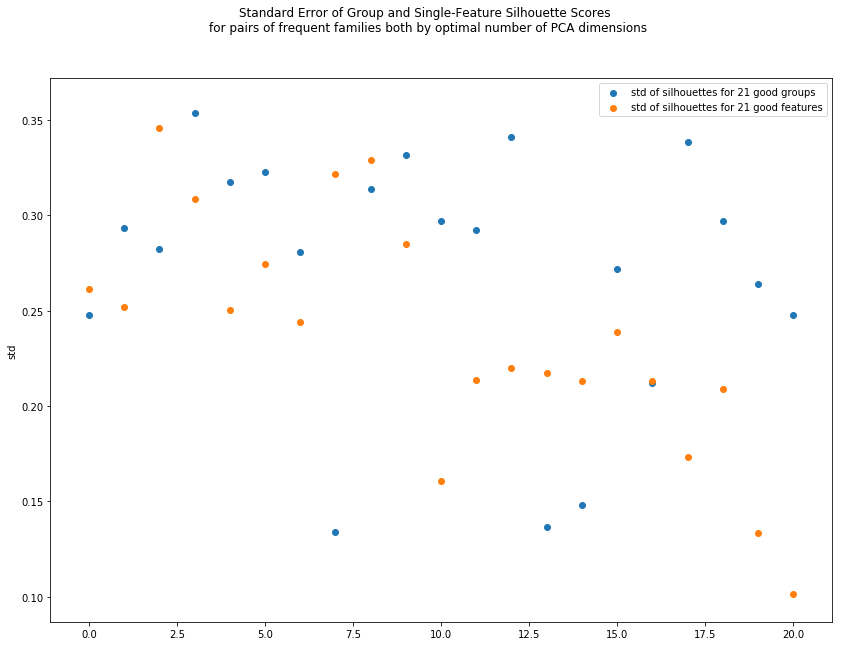

In [18]:
fig,ax = plt.subplots(figsize=(14,10))
x = np.arange(len(bysingle))
ax.scatter(x,bygroup['std'],label='std of silhouettes for 21 good groups')
ax.scatter(x,bysingle['std'],label='std of silhouettes for 21 good features')
ax.set_ylabel('std')
plt.suptitle('Standard Error of Group and Single-Feature Silhouette Scores \
 \nfor pairs of frequent families both by optimal number of PCA dimensions')
plt.legend()
plt.show()

So ** per pairs of families ** you can't say that the deviations are smaller in group analysis.

The values are higher though:

In [19]:
group_average = bygroup['gen2mean'].mean()
single_average = bysingle['gen2mean'].mean()
print("Average Silhouette Scores  -- mean of pairs -- of 21 Groups: {:.2f}\n \
\rAverage Silhuoette Scores -- mean of pairs -- of 21 Features: {:.2f}".format(group_average,single_average))

Average Silhouette Scores  -- mean of pairs -- of 21 Groups: 0.42
Average Silhuoette Scores -- mean of pairs -- of 21 Features: 0.30


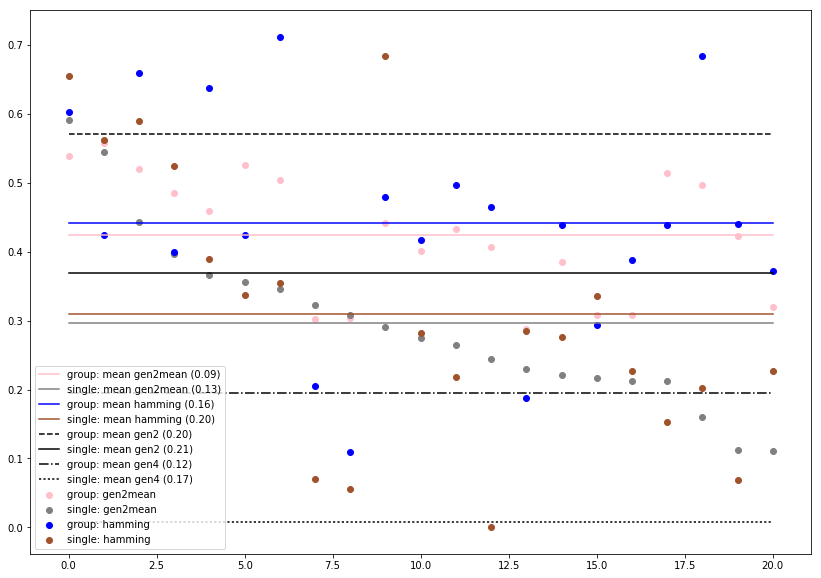

In [20]:
fig,ax = plt.subplots(figsize=(14,10))
x = np.arange(len(bysingle))
lines = [':','-.','-','--']
colors = copy.deepcopy(ColGroup.colors)
for gen in ['gen2mean','hamming']:
    for meth in ['group','single']:
        df = eval('by'+meth)
        c = colors.pop()
        ax.scatter(x,df[gen],label='{}: {}'.format(meth,gen),color=c)
        ax.plot((x[0],x[-1]),(df[gen].mean(),df[gen].mean()),
                color=c,
                label='{}: mean {} ({:.2f})'.format(meth,gen,df[gen].std())
        )
for gen in ['gen2','gen4']:
    for meth in ['group','single']:
        df = eval('by'+meth)
        line = []
        ax.plot((x[0],x[-1]),
                (df[gen].mean(),df[gen].mean()),
                lines.pop(),
                color='black',
                label='{}: mean {} ({:.2f})'.format(meth,gen,df[gen].std())
               )
plt.legend()
plt.show()